# Setting up depedencies

**April 09 2021**


The data folder is `experiments/g5k/data/connections_experiment/paravance`.


In [1]:
%load_ext rpy2.ipython

In [2]:
import sys 
import os
import math
import datetime
import glob
import json
import re
import pprint
import pandas as pd
from subprocess import *
import subprocess
import numpy as np
from importlib import reload  # Python 3.4+ only.
from IPython.display import Image

cwd = os.getcwd()
print(cwd)
# Adapt this path, it needs to point on the folder containing experiments/exptools.py.
sys.path.insert(1, os.path.abspath("src"))
import analysis
reload(analysis)

/home/adfaure/Projects/ptask-eval/analysis


<module 'analysis' from '/home/adfaure/Projects/ptask-eval/analysis/src/analysis.py'>

In [2]:
%%R -w 18 -h 8 --units in
library(tidyverse)
library(viridis)
library(extrafont)

theme_set(theme_minimal(base_size = 18))

load_instance_grisou = function(path, noise) {
    instance = path
    data = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "Router (eno1)", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Router (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Tcpkali", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-11.rennes.grid5000.fr.eno1.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "MPI (only one host)", timestamp = timestamp - min(timestamp)) ) %>%
    mutate(noise = noise)
}


Error in library(extrafont) : there is no package called ‘extrafont’


/nix/store/3dg392sa75qgijha0j1kn51f8fj87z9q-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/nix/store/3dg392sa75qgijha0j1kn51f8fj87z9q-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/nix/store/3dg392sa75qgijha0j1kn51f8fj87z9q-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/nix/store/3dg392sa75qgijha0j1kn51f8fj87z9q-python3-3.7.3-env/lib/python3.7/site-packa

# Preparing the data

These functions loop thgough each configurations, extract the data and create the csv necessary for ploting the progress `mpi_progress.csv`.
This block creates a csv with all configurations.

In [10]:
base_folder = "../experiments/g5k/data/connections_experiment/paravance"

subdiv50 = os.path.join(base_folder, "")

data = []
for file in glob.glob(os.path.join(subdiv50, "*")):
    print(file)
    instances =  analysis.Instances(file)
    if(file.endswith("ibcast")):
        for id_ in instances.instances:
            if(not instances.instances[id_].timeout):
                data.append(("50_subdivision", "IBcast", instances.name.replace("_ibcast", "").replace("256c_", ""), instances.instances[id_].get_runtime2()))
            else:
                print("failed: ", file)
    else:
        for id_ in instances.instances:
            if(not instances.instances[id_].timeout):
                data.append(("50_subdivision", "Bcast", instances.name.replace("_bcast", "").replace("256c_", ""), instances.instances[id_].get_runtime2()))
            else:
                print("failed: ", file)

df = pd.DataFrame(data=data, columns=[ 'nb_sub', 'bcast', 'tcp_connections', 'runtime'])
df.to_csv(os.path.join(base_folder, "paravance_all_instance.csv"))

../experiments/g5k/data/connections_experiment/paravance/2tcp_conn_ibcast
../experiments/g5k/data/connections_experiment/paravance/1tcp_conn_bcast
../experiments/g5k/data/connections_experiment/paravance/256tcp_conn_ibcast
../experiments/g5k/data/connections_experiment/paravance/8tcp_conn_bcast
../experiments/g5k/data/connections_experiment/paravance/32tcp_conn_ibcast
../experiments/g5k/data/connections_experiment/paravance/64tcp_conn_bcast
../experiments/g5k/data/connections_experiment/paravance/16tcp_conn_ibcast
../experiments/g5k/data/connections_experiment/paravance/100tcp_conn_bcast
../experiments/g5k/data/connections_experiment/paravance/128tcp_conn_bcast
../experiments/g5k/data/connections_experiment/paravance/100tcp_conn_ibcast
../experiments/g5k/data/connections_experiment/paravance/4tcp_conn_ibcast
../experiments/g5k/data/connections_experiment/paravance/1tcp_conn_ibcast
../experiments/g5k/data/connections_experiment/paravance/4tcp_conn_bcast
../experiments/g5k/data/connectio

# Visualisation

First we print the bar plot of the different running times.
On can see, that none of the instances with 1 subdivisions, and blocking bcast suceed to finish before the timeout (of 45min).

In [3]:
%%R -w 12 -h 7 --units in

library(tidyverse)
library(ggplot2)
library(viridis)

ilevels = c("0",
            "1",    
            "2",
            "4",
            "8", 
            "16",
            "32",  
            "64",
            "100",
            "128",
            "256")

theme_set(theme_minimal(base_size = 18))

path = "../experiments/g5k/data/connections_experiment/paravance/"

data = read_csv("../experiments/g5k/data/connections_experiment/paravance/paravance_all_instance.csv") %>% 
    mutate(tcp_connections = str_replace(tcp_connections, "tcp_conn", "")) %>%
    mutate(tcp_connections = str_replace(tcp_connections, "nokali", "0")) %>%
    mutate(nb_sub = str_replace(nb_sub, "1_subdivision", "No subdivision"), 
           nb_sub = str_replace(nb_sub, "50_subdivision", "50 subdivisions")) %>%
    mutate(nb_sub = factor(nb_sub, levels = c("No subdivision", "50 subdivisions"))) %>% 
    mutate(bcast = str_replace(bcast, "IBcast", "Immediate broadcast"),
           bcast = str_replace(bcast, "Bcast", "Blocking broadcast"))

stats <- data %>% group_by(tcp_connections, nb_sub, bcast) %>% 
    summarise( sd_time = sd(runtime), mean_runtime = mean(runtime), n = n())

stats %>% ggplot(aes(y = mean_runtime, x = tcp_connections, fill = bcast)) +
    geom_bar(stat = "identity", position = position_dodge())+  
    xlab("tcp_connetions") + ylab("Application running time (s)") +
    facet_grid(~nb_sub) + 
    geom_errorbar(aes(ymin = mean_runtime - sd_time, ymax = mean_runtime + sd_time), 
                  position = position_dodge(0.9), width = 0.5) +
    scale_fill_viridis_d(end = 0.6) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    theme_bw(base_size = ) +
    theme(legend.position = "bottom")

# We compute the increase percentage of interference compared to the run without interference
# - Mean runtime for each config
# - Find the config with the lowest (mean) runtime (should be the no interference)
# - Attach this runtime to the others means and compute the increase percentage ((mean_runtime - base) / base) * 100 
sums = data %>% group_by(bcast, nb_sub, tcp_connections) %>%
  summarize(mean = mean(runtime), sd = sd(runtime))

find_base = sums %>% group_by(bcast, nb_sub) %>% summarise(base = min(mean))

inc_percentages = full_join(sums, find_base, by= c("nb_sub", "bcast")) %>% 
  mutate(inc_percentage = (mean - base ) / base * 100, key = paste(bcast, nb_sub)) %>%
    write_csv("data/paravance_connections_apr_09_2021.csv")

/nix/store/3dg392sa75qgijha0j1kn51f8fj87z9q-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Parsed with column specification:
cols(
  X1 = col_double(),
  nb_sub = col_character(),
  bcast = col_character(),
  tcp_connections = col_character(),
  runtime = col_double()
)

  warnings.warn(x, RRuntimeWarning)


/nix/store/3dg392sa75qgijha0j1kn51f8fj87z9q-python3-3.7.3-env/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:155: RRuntimeWarning: Saving 12 x 7 in image

  warnings.warn(x, RRuntimeWarning)


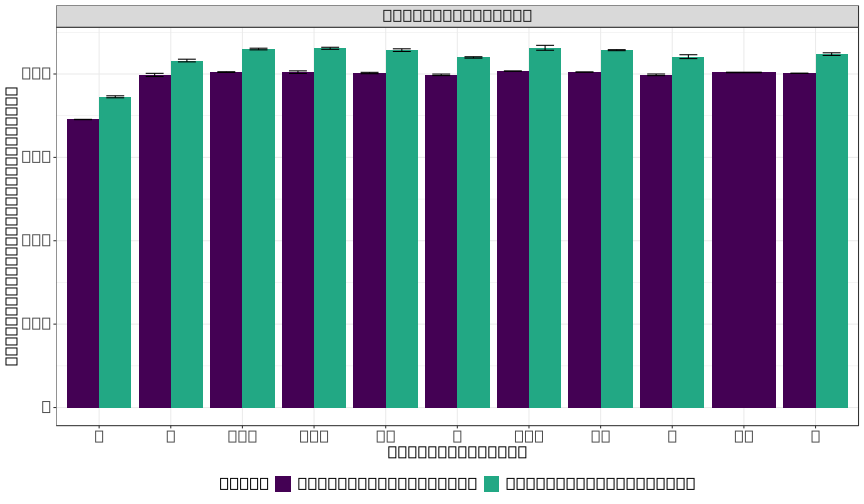

In [4]:
%%R -w 12 -h 7 --units in

t_alpha = 1.96

stats %>% ggplot(aes(y = mean_runtime, x = tcp_connections, fill = bcast)) +
    geom_bar(stat = "identity", position = position_dodge())+  
    xlab("tcp_connetions") + ylab("Application running time (s)") +
    facet_grid(~nb_sub) + 
    geom_errorbar(aes(ymin = mean_runtime - (t_alpha * (sd_time / sqrt(n))), ymax = mean_runtime + (t_alpha * (sd_time / sqrt(n)))), 
                  position = position_dodge(0.9), width = 0.5) +
    scale_fill_viridis_d(end = 0.6) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    theme_bw(base_size = ) +
    theme(legend.position = "bottom") +
    ggsave("/tmp/paravance_variable.pdf")

# A tibble: 21 x 8
# Groups:   bcast, nb_sub [2]
   bcast    nb_sub  tcp_connections  mean     sd  base inc_percentage key       
   <chr>    <chr>   <chr>           <dbl>  <dbl> <dbl>          <dbl> <chr>     
 1 Blockin… 50 sub… 0                345. 0.146   345.            0   Blocking …
 2 Blockin… 50 sub… 1                399. 1.38    345.           15.5 Blocking …
 3 Blockin… 50 sub… 100              402. 0.313   345.           16.5 Blocking …
 4 Blockin… 50 sub… 128              402. 1.14    345.           16.4 Blocking …
 5 Blockin… 50 sub… 16               401. 0.583   345.           16.1 Blocking …
 6 Blockin… 50 sub… 2                399. 0.656   345.           15.5 Blocking …
 7 Blockin… 50 sub… 256              403. 0.107   345.           16.8 Blocking …
 8 Blockin… 50 sub… 32               402. 0.0886  345.           16.5 Blocking …
 9 Blockin… 50 sub… 4                399. 0.716   345.           15.5 Blocking …
10 Blockin… 50 sub… 64               402. 0.208   345.      

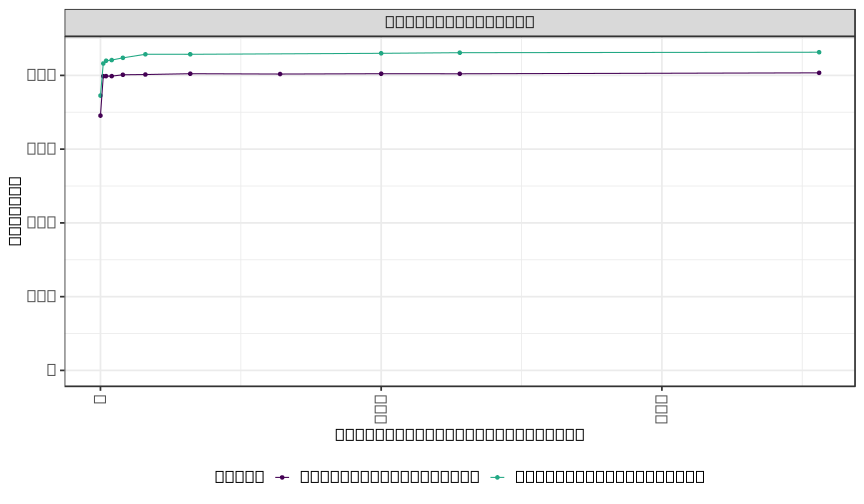

In [5]:
%%R -w 12 -h 7 --units in

print(inc_percentages)
inc_percentages %>% 
    ggplot(aes(y = mean, group = key, x = as.numeric(tcp_connections), color = bcast)) +
    geom_point() +
    geom_line() +
    expand_limits(x = 0, y = 0) +
    facet_grid(~nb_sub) +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime") + 
    xlab("Number of TCP connections") + 
    theme(legend.position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggsave("/tmp/paravance_connections.pdf")
    

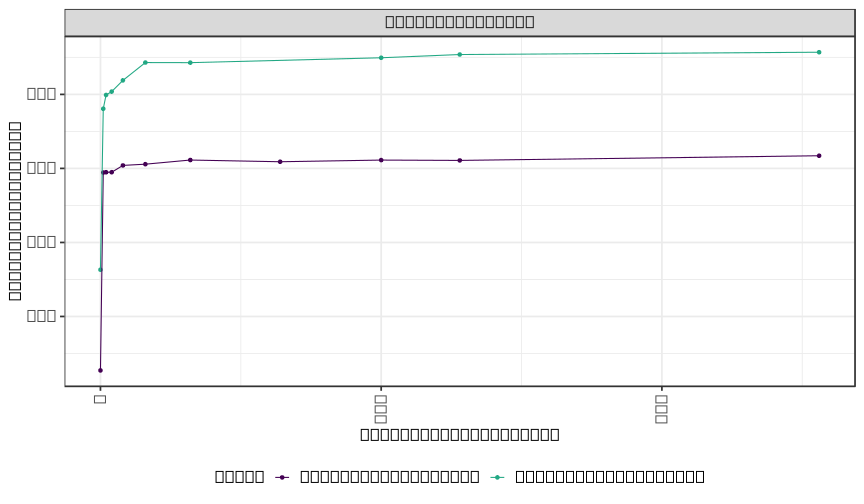

In [6]:
%%R -w 12 -h 7 --units in

inc_percentages %>% 
    ggplot(aes(y = mean, group = key, x = as.numeric(tcp_connections), color = bcast)) +
    geom_point() +
    geom_line() +
    # scale_y_log10() + 
    facet_grid(~nb_sub) +
    scale_color_viridis_d(end = 0.6) + 
    theme_bw(base_size = 18) +
    ylab("Runtime % increase") + 
    xlab("Interference pattern") + 
    theme(legend.position = "bottom") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggsave("/tmp/paravance_percentage_inc.pdf")

[1] "../experiments/g5k/data/connections_experiment/paravance/nokali_bcast"


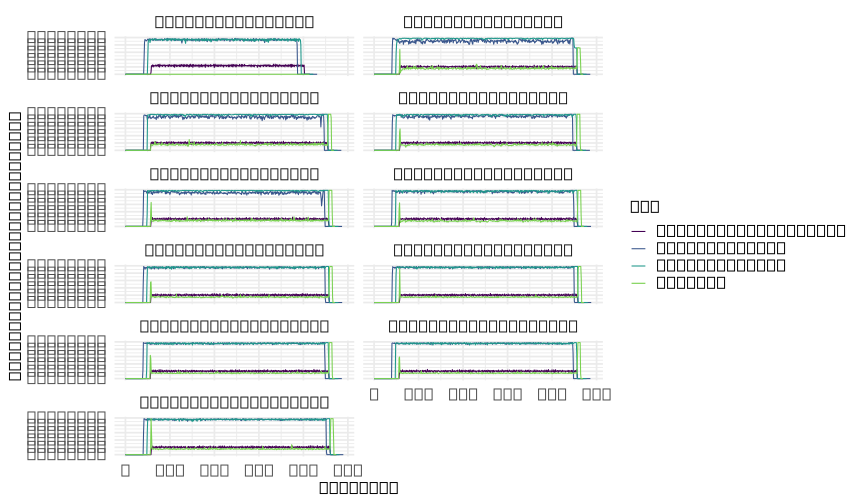

In [38]:
%%R -w 12 -h 7 --units in

ilevels = c("0 TCP connection",
            "1 TCP connection",    
            "2 TCP connections",
            "4 TCP connections",
            "8 TCP connections", 
            "16 TCP connections",
            "32 TCP connections",  
            "64 TCP connections",
            "100 TCP connections",
            "128 TCP connections",
            "256 TCP connections")

print(paste0(path, "nokali_bcast"))

load_instance_grisou = function(path, noise) {
    instance = path
    data = read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno1.mojitos.csv")) %>% 
        rename(timestamp = "#timestamp") %>% mutate(src = "Router (eno1)", timestamp = timestamp - min(timestamp)) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-1.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Router (eno2)", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-10.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>%  mutate(src = "Tcpkali", timestamp = timestamp - min(timestamp)) ) %>% 
    bind_rows( read_table2(paste0(instance, "paravance-11.rennes.grid5000.fr.eno2.mojitos.csv")) %>%
        rename(timestamp = "#timestamp") %>% mutate(src = "MPI (only one host)", timestamp = timestamp - min(timestamp)) ) %>%
    mutate(noise = noise)
}

data = bind_rows( load_instance_grisou(get_instance_folder(paste0(path, "1tcp_conn_bcast"), 1), "1 TCP connection"), 
        list(
          load_instance_grisou(get_instance_folder(paste0(path, "nokali_bcast"), 1), "0 TCP connection"),
          load_instance_grisou(get_instance_folder(paste0(path, "2tcp_conn_bcast"), 1), "2 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "4tcp_conn_bcast"), 1), "4 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "8tcp_conn_bcast"), 1), "8 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "16tcp_conn_bcast"), 1), "16 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "32tcp_conn_bcast"), 1), "32 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "64tcp_conn_bcast"), 1), "64 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "128tcp_conn_bcast"), 1), "128 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "256tcp_conn_bcast"), 1), "256 TCP connections"),
          load_instance_grisou(get_instance_folder(paste0(path, "100tcp_conn_bcast"), 1), "100 TCP connections")))

data  %>%
    mutate(noise = factor(noise, levels = ilevels)) %>%
    ggplot(aes(x = timestamp, y = txb)) + 
        ylab("transferred bytes (bytes/s)") + xlab("Time (s)") +
        geom_line(aes(color = src)) + facet_wrap(~noise, ncol = 2) +
        scale_colour_viridis_d(end = 0.8) +
        ggsave("/tmp/paravance_connections_monitoring.pdf")

## Find the number of connections

This notebook emphasis that the number of TCP connections has a dramatic impact on the runtime of the application.
However, if the number of TCP connections is directly parameterizable with TCPkali, it is difficult to know it for the MPI application.

For the moment, the simpler way to find out the number of tcp connections is to use smpi.

In [1]:
!gemmspi

/nix/store/68sm67lcd4pnmyhijpyh134a7ykgyjhq-bash-interactive-4.4-p23/bin/sh: gemmspi: command not found
